In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# After running the language classifier, we can read the output and call the sentiment analysis pipeline.

In [ ]:
from datetime import timedelta
import glob
from google.colab import drive, runtime 
import numpy as np
from os.path import isfile, basename
import pandas as pd
#from transformers import pipeline
import time

In [ ]:
# Mounts the Google Drive so we can access the CSV files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Reads all the new CSV files
fpaths = glob.glob("gdrive/My Drive/DW - Climate Protests/9.high_engagement_language_detection/*.csv")

In [ ]:
# Reads each csv file and concatenates
df = pd.concat([ pd.read_csv(fpath, dtype=str) for fpath in fpaths]).reset_index()

In [ ]:
# Keep only those that are in English
df = df[df.lang_label == 'en'].reset_index(drop=True)
df.shape

(53073, 17)

<Axes: >

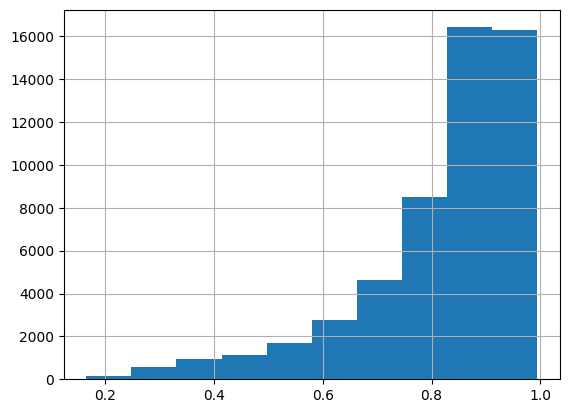

In [ ]:
# How certain are we of the language classification?
df.lang_score.hist()

In [ ]:
# Now we can apply another pre-trainer classifier to the remaining tweets, splitting them into "positive" and "negative".
classifier = pipeline(task="sentiment-analysis", model="siebert/sentiment-roberta-large-english")

In [ ]:
# Functon that runs it through all tweets and saves the answer back to an array
def classify_sentiment(data, classifier):

  # TO DO – Instead of going by chunk, go item by item and save them as JSONs, so we don't
  # have to rerun the entire thing every time.

  result = classifier(data.raw_content.tolist())
  result = pd.DataFrame(result)
  result = result.rename(columns={"label":"sentiment_label", "sentiment_score":"lang_score"})

  return pd.concat([data.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

In [ ]:
# We will split the dataframe in smaller chunks 
# so we don't lose all progress if anything goes wrong
dfs_split = np.array_split(df, 100)

In [ ]:
for index, chunk in enumerate(dfs_split):

  fname = f'gdrive/My Drive/DW - Climate Protests/10.high_engagement_sentiment_analysis/chunk-{index}.csv'

  if isfile(fname):
    continue

  start = time.time()
  
  result = classify_sentiment(chunk, classifier=classifier)
  result.to_csv(fname)

  end = time.time()
  print(f'Chunk {index} processing time:', str(timedelta(seconds=end-start)))

In [ ]:
runtime.unassign()
